In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

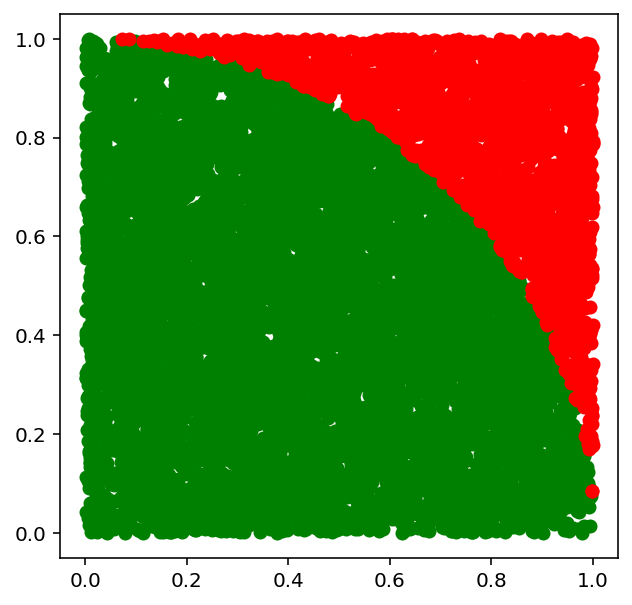

In [15]:
# Monte Carlo simulation for value of pi

def mc_pi(n):
    x = torch.rand(n)
    y = torch.rand(n)
    f = x**2 + y**2 < 1
    ratios = f.float() * 4
    return x, y, f, ratios

def mc_pi_plot(n):
    x, y, f, ratios = mc_pi(n)
    plt.figure(figsize=(5,5))
    # Green points are inside the circle, red points are outside
    plt.scatter(x[f], y[f], color='g')
    plt.scatter(x[~f], y[~f], color='r')
    plt.show()

mc_pi_plot(10000)

In [45]:
# Show the value of pi as a function of the number of points

n = 10000
x, y, f, ratios = mc_pi(n)


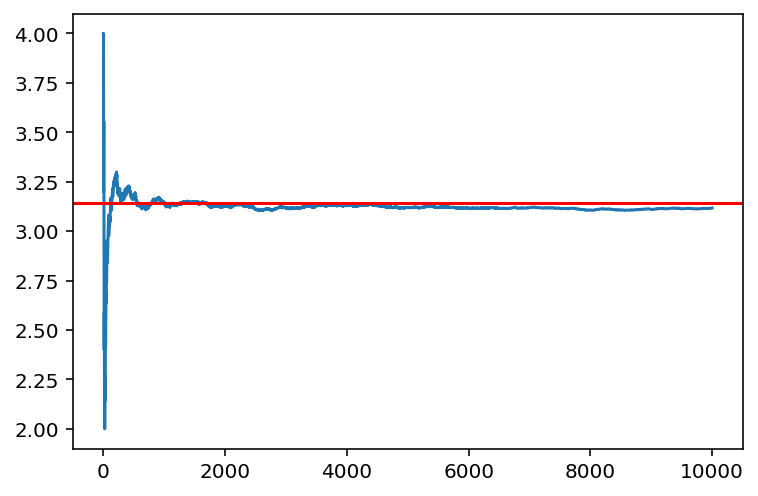

In [46]:
# cumulative sum of ratios
pis = ratios.cumsum(0)/torch.arange(1, n+1)
plt.plot(pis)
plt.axhline(np.pi, color='r')

In [50]:
torch.std(pis, dim=0)

tensor(0.0552)

In [51]:
pis.shape

torch.Size([10000])

In [58]:
pis.shape

torch.Size([10000])

tensor(0.0526)

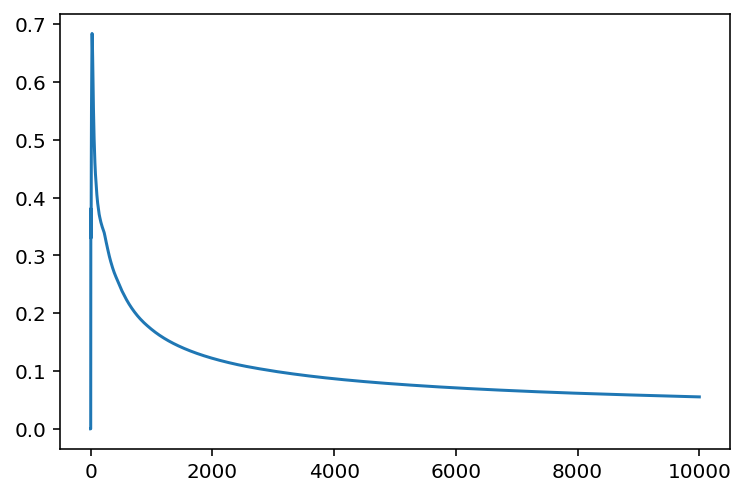

In [57]:
stds = []
for i in range(1, n+1):
    stds.append(pis[:i].std())
plt.plot(stds)


In [55]:
indices = torch.arange(1, n+1).unsqueeze(1)
stds = torch.std(pis[:indices], dim=1)

TypeError: only integer tensors of a single element can be converted to an index

In [53]:
pis[:torch.arange(1, n+1)]

TypeError: only integer tensors of a single element can be converted to an index

In [56]:
cumsum_pis = pis.cumsum(dim=0)
range_values = torch.arange(1, n+1).unsqueeze(1)
stds = torch.std(cumsum_pis[:range_values], dim=1)

TypeError: only integer tensors of a single element can be converted to an index